# Exercise 3

## Import packages

In [11]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [ ]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # If CUDA is enabled, move data and target to the GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    return loss.item()      #Return loss

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [ ]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data, target = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

    return 100. * correct / len(test_loader.dataset)        #Return accuracy

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet3"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [14]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.name = 'FCNet1'
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(784, 200)
        self.linear1 = nn.Linear(200, 100)
        self.linear2 = nn.Linear(100, 60)
        self.linear3 = nn.Linear(60, 30)
        self.linear4 = nn.Linear(30, 10)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        x = self.linear0(x)
        x = self.sigmoid(x)
        x = self.linear1(x)
        x = self.sigmoid(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        x = self.linear4(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x)
                
        return output

In [15]:
class FCNet2(nn.Module):
    def __init__(self):
        super(FCNet2, self).__init__()
        
        self.name = 'FCNet2'
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(784, 200)
        self.linear1 = nn.Linear(200, 100)
        self.linear2 = nn.Linear(100, 60)
        self.linear3 = nn.Linear(60, 30)
        self.linear4 = nn.Linear(30, 10)
        self.relu = nn.ReLU()
    

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x)
                
        return output

In [16]:
class FCNet3(nn.Module):
    def __init__(self):
        super(FCNet3, self).__init__()
        self.name = 'FCNet3'
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(784, 200)
        self.linear1 = nn.Linear(200, 100)
        self.linear2 = nn.Linear(100, 60)
        self.linear3 = nn.Linear(60, 30)
        self.linear4 = nn.Linear(30, 10)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(200)
        self.batchnorm3 = nn.BatchNorm1d(60)

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run network layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.batchnorm3(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)

        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x)

        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

Output Size= [(Input Size-Kernel Size+2*Padding​)/Stride]+1

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [17]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        self.name = 'ConvNet1'
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.linear0 = nn.Linear(9216, 128)
        self.linear1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        # TODO: initialize network layers
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv0(x)
        x = self.relu(x)
        x= self.conv1(x)
        x = self.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        x = self.relu(x)
                
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
        
        
        return output

In [18]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.name = 'ConvNet2'
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.linear0 = nn.Linear(9216, 128)
        self.linear1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = self.conv0(x)
        x = self.relu(x)
        x = self.batchnorm0(x)
        x= self.conv1(x)
        x = self.relu(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.linear1(x)
        x = self.relu(x)
                
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
    
        return output

In [19]:
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.name = 'ConvNet3'
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.linear0 = nn.Linear(9216, 128)
        self.linear1 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv0(x)
        x = self.relu(x)
        x = self.batchnorm0(x)
        x= self.conv1(x)
        x = self.relu(x)

        #maxpooling
        x = self.maxpool(x)
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = self.flatten(x)
        
        # TODO: run fully connected layers
        x = self.linear0(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.linear1(x)
        x = self.relu(x)
                
        # TODO: compute log softmax over the output
        output = F.log_softmax(x)
    
        return output

model: FCNet1
model: FCNet2
model: FCNet3
model: ConvNet1
model: ConvNet2
model: ConvNet3
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309338


/tmp/ipykernel_87850/4109835594.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.074221
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.084538
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.021039
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.070544
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.080904
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.086612
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.015615
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.101668
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.018705

Test set: Average loss: 0.0918, Accuracy: 9678/10000 (96.78%)



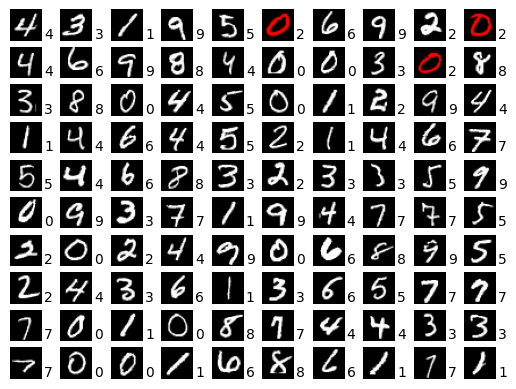

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.051780
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.024798
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.025499
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.058824
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.073360
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.013728
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.003890
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.006689
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.012899
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.010017

Test set: Average loss: 0.0301, Accuracy: 9898/10000 (98.98%)



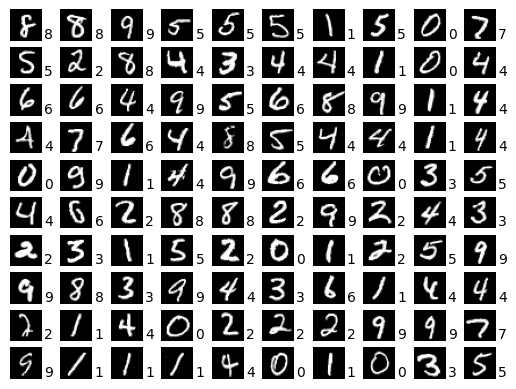

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.013010
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.000577
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.002947
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.008490
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.002861
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.003881
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.006208
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.004440
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.010629
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.003252

Test set: Average loss: 0.0305, Accuracy: 9906/10000 (99.06%)



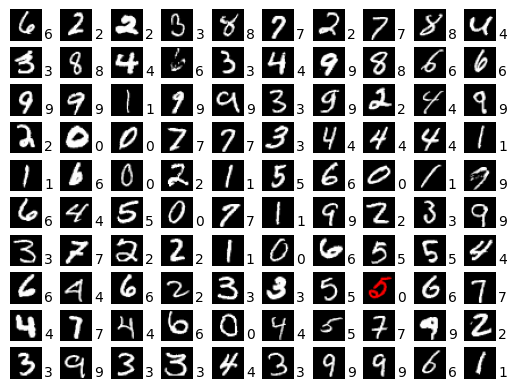

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.029947
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.001884
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.002576
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.003249
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.004363
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.000251
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.003203
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.070750
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000344
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.008519

Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)



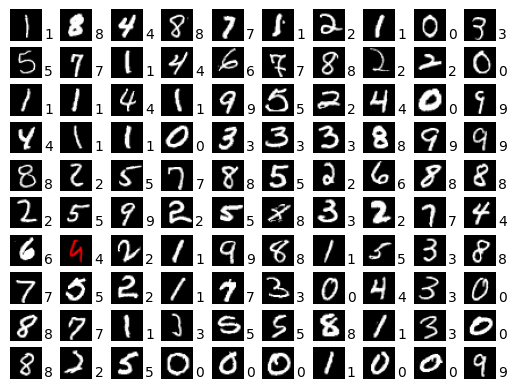

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.001431
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.004603
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.003155
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.000569
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.003071
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.004800
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.024281
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.002333
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000475
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.000103

Test set: Average loss: 0.0305, Accuracy: 9913/10000 (99.13%)



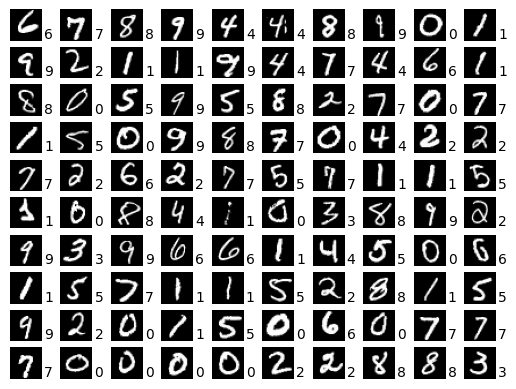

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000180
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.006385
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.001344
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.006677
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.012134
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.001151
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.006871
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.011629
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.001853
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.000873

Test set: Average loss: 0.0292, Accuracy: 9916/10000 (99.16%)



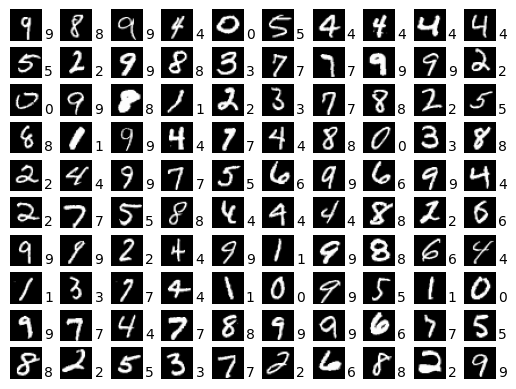

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000556
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000095
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.001306
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.001242
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.003387
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000244
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.002673
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.000508
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.000864
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.000062

Test set: Average loss: 0.0309, Accuracy: 9911/10000 (99.11%)



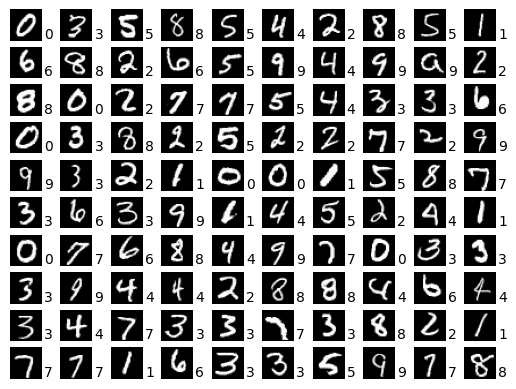

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.005430
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.001985
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.000541
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.000446
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000608
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.001093
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.000358
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000163
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000286
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000213

Test set: Average loss: 0.0309, Accuracy: 9916/10000 (99.16%)



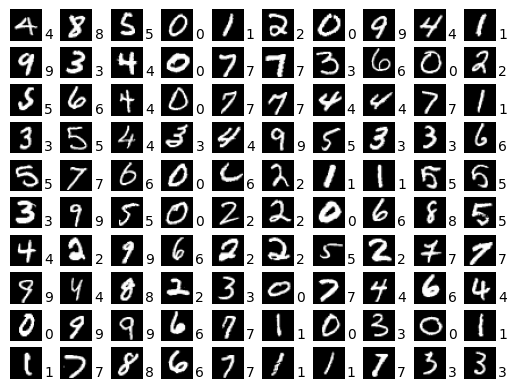

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.001247
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.001563
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.000407
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000371
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.005605
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.001006
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000608
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.000081
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000312
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000180

Test set: Average loss: 0.0313, Accuracy: 9913/10000 (99.13%)



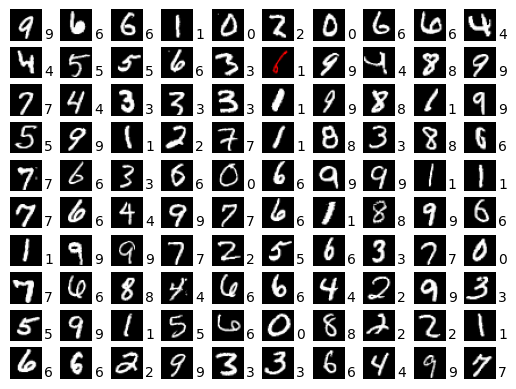

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000261
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000682
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.000261
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.003080
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.005900
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000043
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000156
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000312
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.000063
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.000162

Test set: Average loss: 0.0307, Accuracy: 9912/10000 (99.12%)



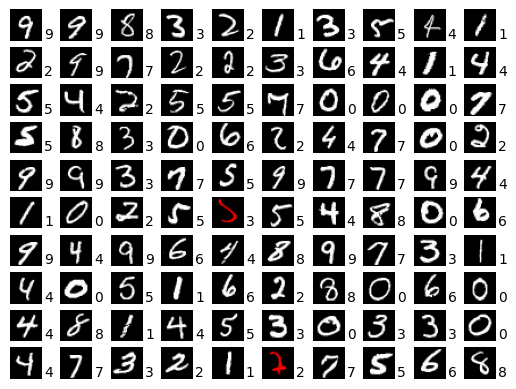

In [20]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

modellist = [
    FCNet1(),  
    FCNet2(),  
    FCNet3(), 
    ConvNet1(),
    ConvNet2(),
    ConvNet3()
    ]

data = {}
file_path = "data.json" 

# Check if the file exists 
if not os.path.isfile(file_path): # Create the file 
    with open(file_path, 'w') as file:
        file.write('{}')

with open(file_path, 'r') as json_file:
    data = json.load(json_file)

for model in modellist:
    print(f"model: {model.name}")
    if model.name in data:
        continue

    loss = []
    acc = []
    data[model.name] = {}
    if use_cuda:
        model = model.cuda()

    # initialize optimizer and scheduler
    optimizer = optim.Adadelta(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    for epoch in range(0, epochs):
        # train one epoch
        loss.append(train(model, use_cuda, train_loader, optimizer, epoch, log_interval))
        
        # run on test dataset
        acc.append(validate(model, use_cuda, test_loader))
        scheduler.step()

    data[str(model.name)] = {'acc': acc, 'loss': loss}

    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")
###------------------------------------------------- ganz unten folgen plots zu allen implementierten Netzwerken

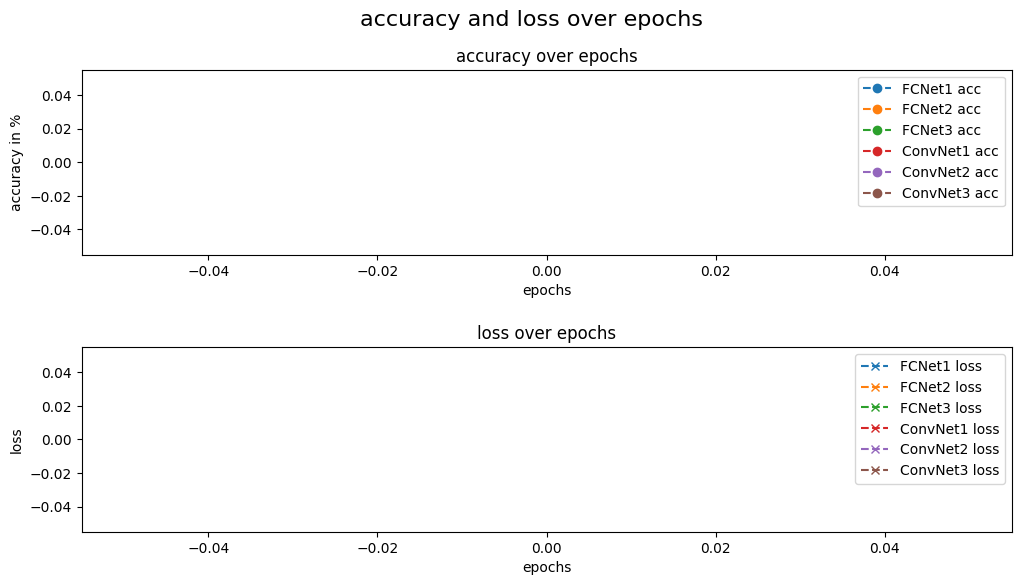

In [21]:
# def plotdata(gput:list, cput:list, gpuacc:list, cpuacc:list) -> None:
def plotdata(dataDict:dict,) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)

    fig.suptitle('accuracy and loss over epochs', fontsize=16)

    for model in dataDict:
        ax1.plot(dataDict[model]['acc'], 'o--',  label=f'{model} acc')
        ax2.plot(dataDict[model]['loss'], 'x--',  label=f'{model} loss')

    ax1.set_title("accuracy over epochs")
    ax1.set_ylabel("accuracy in %")
    ax1.set_xlabel("epochs")

    ax2.set_title("loss over epochs")
    ax2.set_ylabel("loss")
    ax2.set_xlabel("epochs")

    ax2.legend()
    ax1.legend()
    plt.savefig("Model_Vergleich.png")

with open("data.json", 'r') as json_file:
    data = json.load( json_file)

plotdata(dataDict=data)